In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os, sys

# Get the absolute path to the src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Add src_path to the system path
sys.path.insert(0, src_path)

from utils import mappings

PUBLICATIONS_PATH = "../../data/raw/publication_meta/br_publication_meta.csv"

In [2]:
def plot_subfield_country_heatmap(df, normalize=True):
    # Define subfields and their display order
    subfield_order = [
        "Computer Vision and Pattern Recognition",
        "Information Systems",
        "Computational Theory and Mathematics",
        "Artificial Intelligence",
        "Computer Networks and Communications",
        "Computer Science Applications",
        "Software",
        "Signal Processing",
        "Human-Computer Interaction",
        "Hardware and Architecture",
        "Computer Graphics and Computer-Aided Design",
    ]

    subfield_order = sorted(subfield_order)

    # Define countries and their display order
    country_order = ["US", "PT", "ES", "GB", "FR", "IT", "DE", "CA", "CN", "IN"]

    # Parse JSON columns
    df["subfield"] = df["subfield"].apply(json.loads)
    df["authorships"] = df["authorships"].apply(json.loads)

    # Filter and prepare data
    valid_subfields = set(subfield_order)
    df["subfield_name"] = df["subfield"].apply(lambda x: x["display_name"])
    df = df[df["subfield_name"].isin(valid_subfields)]

    # Create count matrix
    count_matrix = pd.DataFrame(0, index=subfield_order, columns=country_order)

    # Calculate international collaborations (excluding BR-only authors)
    for _, row in df.iterrows():
        subfield = row["subfield_name"]
        for author in row["authorships"]:
            # Remove BR from countries and filter valid countries
            countries = [c for c in author.get("countries", []) if c != "BR"]
            valid_countries = [c for c in countries if c in country_order]

            # Count each valid country (multiple countries per author allowed)
            for country in valid_countries:
                count_matrix.loc[subfield, country] += 1

    # Convert country codes to display names
    # count_matrix = count_matrix.rename(columns=mappings.COUNTRY_CODES)
    # Convert subfield names to display names
    count_matrix = count_matrix.rename(index=mappings.SUBFIELDS_SHORT)

    # Normalization logic
    if normalize:
        row_sums = count_matrix.sum(axis=1)
        normalized_matrix = count_matrix.div(row_sums, axis=0).fillna(0) * 100
        data_to_plot = normalized_matrix
        fmt = ".1f"
        cbar_label = "Percentage of International Authors"
    else:
        data_to_plot = count_matrix
        fmt = "d"
        cbar_label = "Number of International Authors"

    # Visualization
    plt.figure(figsize=(10, 8))
    fig = sns.heatmap(
        data_to_plot,
        annot=True,
        fmt=fmt,
        cmap="Blues",
        cbar_kws={"label": cbar_label},
        linewidths=0.5,
        vmin=0,
        vmax=50 if normalize else None,
    )

    title = "Brazilian Publications: International Collaborations by Subfield"
    if normalize:
        title += "\n(Normalized Percentage of Non-Brazilian Authors)"
    else:
        title += "\n(Absolute Count of Non-Brazilian Authors)"

    plt.title(title, fontsize=14, pad=20)
    plt.xlabel("Collaborating Country", fontsize=12)
    plt.ylabel("Subfield", fontsize=12)
    plt.xticks(rotation=0, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    plt.savefig("../../results/figures/inter_collabs_heatmap.pdf", format="pdf")

    return fig

In [3]:
publications_df = pd.read_csv(PUBLICATIONS_PATH)

<Axes: title={'center': 'Brazilian Publications: International Collaborations by Subfield\n(Normalized Percentage of Non-Brazilian Authors)'}, xlabel='Collaborating Country', ylabel='Subfield'>

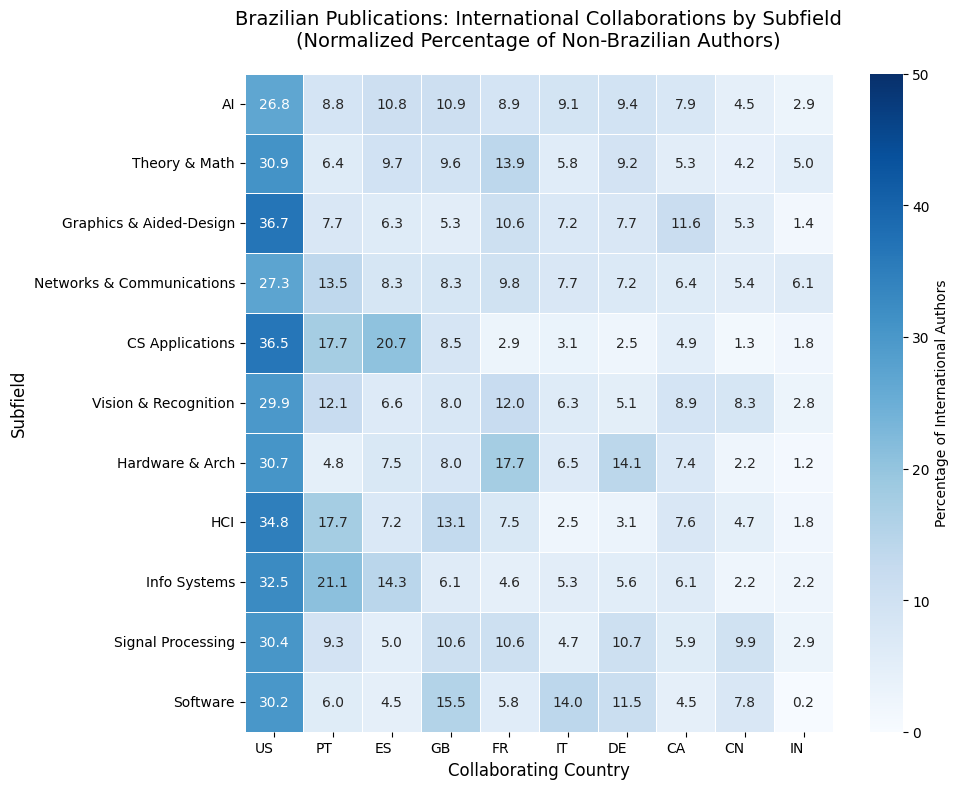

In [4]:
plot_subfield_country_heatmap(publications_df)
plt.show()